In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from joblib import load, dump
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
main_data_path = "../../data/main_data/"
nulls_path = "../../data/nulls.csv"
other_data_path = "../../data/other_data/"
label_path = "../../data/training_label.csv"
feature_imp_path = "../../data/non_corr_features.npy"
# feature_imp_path = "../../data/low_imp_features.joblib"
submission_path = "../../data/sample submission.csv"
pred_cols = ["Mean_BMI","Median_BMI","Unmet_Need_Rate","Under5_Mortality_Rate","Skilled_Birth_Attendant_Rate","Stunted_Rate"]
col_name = 'Stunted_Rate'
random_seed = 42

In [3]:
feat = np.load(feature_imp_path)
# feat = load(feature_imp_path)
len(feat)

2689

In [4]:
def mcrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return np.average(rmse)

In [5]:
df = pd.read_parquet(main_data_path)
df.drop(columns=[col for col in df.columns if col not in feat], inplace=True)
df

,Es_mean@CAS/IGSNRR/PML/V2&timestamped,qc_mean@CAS/IGSNRR/PML/V2&timestamped,ET_water_min_min@CAS/IGSNRR/PML/V2&timestamped,Es_max_min@CAS/IGSNRR/PML/V2&timestamped,GPP_max_max@CAS/IGSNRR/PML/V2&timestamped,GPP_min_min@CAS/IGSNRR/PML/V2&timestamped,qc_min_min@CAS/IGSNRR/PML/V2&timestamped,basic_demographic_characteristics_min_min@CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics&timestamped,data_context@CIESIN/GPWv411/GPW_Data_Context,data_context_min@CIESIN/GPWv411/GPW_Data_Context,...,stable_lights_skew@NOAA/DMSP-OLS/NIGHTTIME_LIGHTS&timestamped,population_stdDev@WorldPop/GP/100m/pop&timestamped,water_stdDev@GLCF/GLS_WATER&timestamped,change-confidence_stdDev@COPERNICUS/Landcover/100m/Proba-V-C3/Global&timestamped,walking_only_travel_time_1000,motorized_only_friction_surface_1000,motorized_only_friction_surface_2000,walking_only_friction_surface_100000,motorized_only_friction_surface_100000,motorized_only_travel_time_100000
DHSID,,,,,,,,,,,,,,,,,,,,,
AL200800000001,0.703046,0.000000,-0.994539,1.245106,13.503246,0.468759,0,0.426325,0.0,0,...,255,255,255,255,195,0.0015,0.001625,0.043573,0.014725,47.410877
AL200800000002,0.636434,0.000000,-0.994539,0.924236,10.946385,0.472322,0,0.090859,0.0,0,...,255,255,255,255,39,0.0020,0.001875,0.039097,0.012322,38.932705
AL200800000003,0.764483,0.000000,-0.994539,0.903424,10.620950,0.464161,0,0.336782,0.0,0,...,255,255,255,255,56,0.0015,0.002750,0.039717,0.013806,43.192800
AL200800000004,0.676971,0.000000,-0.994539,1.363256,10.598937,0.467765,0,0.533822,0.0,0,...,255,255,255,255,179,0.0020,0.001750,0.043162,0.014495,46.634487
AL200800000005,0.634081,0.000000,-0.994539,1.116209,10.791335,0.582110,0,0.541261,0.0,0,...,255,255,255,255,144,0.0020,0.001625,0.043852,0.012748,43.546497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NG200800000718,1.005747,15.376702,-0.994539,1.670800,5.632463,0.000000,0,12.195334,0.0,0,...,255,255,255,255,11,0.0005,0.001025,0.053384,0.007324,62.738655
NG200800000719,1.260059,16.639208,-0.994539,4.638987,0.000000,0.000000,0,2.422746,0.0,0,...,255,255,255,255,0,0.0010,0.000750,0.050933,0.008096,58.283382
NG200800000720,0.617611,13.818388,-0.994539,-1.000000,-1.000000,-1.000000,255,2.422619,0.0,0,...,255,255,255,255,11,0.0012,0.001200,0.049486,0.008825,58.816376


In [6]:
# nulls = pd.read_csv(nulls_path)
# nulls = nulls[nulls['0'] > 0.0]['Unnamed: 0'].values
# df.drop(columns=nulls, inplace=True)
# df = df[~df.index.duplicated(keep='first')]

In [10]:
other_df = pd.read_parquet(other_data_path)
other_df = other_df[~other_df.index.duplicated(keep='first')]

In [11]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['DHSCC', 'URBAN_RURA', 'DHSREGNA']),
    remainder='passthrough')

transformed = transformer.fit_transform(other_df)
transformed_df = pd.DataFrame(transformed.todense(), columns=transformer.get_feature_names_out())
transformed_df.index = other_df.index

In [12]:
transformed_df.drop(columns=[col for col in transformed_df.columns if col not in feat], inplace=True)
transformed_df

,onehotencoder__DHSCC_AL,onehotencoder__DHSCC_AM,onehotencoder__DHSCC_AO,onehotencoder__DHSCC_BD,onehotencoder__DHSCC_BF,onehotencoder__DHSCC_BJ,onehotencoder__DHSCC_BO,onehotencoder__DHSCC_BU,onehotencoder__DHSCC_CD,onehotencoder__DHSCC_CF,...,onehotencoder__DHSREGNA_yaound /douala,onehotencoder__DHSREGNA_yerevan,onehotencoder__DHSREGNA_zinda /diffa,onehotencoder__DHSREGNA_zinder,onehotencoder__DHSREGNA_zomba,onehotencoder__DHSREGNA_zou,onehotencoder__DHSREGNA_zuguinchor,remainder__DHSYEAR,remainder__LATNUM,remainder__LONGNUM
DHSID,,,,,,,,,,,,,,,,,,,,,
AL200800000001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.822650,19.838322
AL200800000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.696846,20.007555
AL200800000003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.750040,19.974262
AL200800000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.798930,19.863338
AL200800000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.746124,19.843885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NG200800000718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,5.071090,7.334520
NG200800000719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,5.131400,7.340280
NG200800000720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,5.162330,7.301888


In [13]:
df = df.join(transformed_df, how='left')

In [14]:
labels = pd.read_csv(label_path, index_col='DHSID')
labels.drop(columns=['URBAN_RURA', 'DHSYEAR', 'DHSCLUST', 'LATNUM', 'LONGNUM'], inplace=True)

In [15]:
df = df.join(labels, how='left')
df = df[~df.index.duplicated(keep='first')]

In [16]:
y = df[col_name]
X = df.drop(pred_cols, axis=1)
df = X.join(y)
df1 = df.dropna()
y = df1[col_name]
X = df1.drop(col_name, axis=1)

In [21]:
X

,Es_mean@CAS/IGSNRR/PML/V2&timestamped,qc_mean@CAS/IGSNRR/PML/V2&timestamped,ET_water_min_min@CAS/IGSNRR/PML/V2&timestamped,Es_max_min@CAS/IGSNRR/PML/V2&timestamped,GPP_max_max@CAS/IGSNRR/PML/V2&timestamped,GPP_min_min@CAS/IGSNRR/PML/V2&timestamped,qc_min_min@CAS/IGSNRR/PML/V2&timestamped,basic_demographic_characteristics_min_min@CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics&timestamped,data_context@CIESIN/GPWv411/GPW_Data_Context,data_context_min@CIESIN/GPWv411/GPW_Data_Context,...,onehotencoder__DHSREGNA_yaound /douala,onehotencoder__DHSREGNA_yerevan,onehotencoder__DHSREGNA_zinda /diffa,onehotencoder__DHSREGNA_zinder,onehotencoder__DHSREGNA_zomba,onehotencoder__DHSREGNA_zou,onehotencoder__DHSREGNA_zuguinchor,remainder__DHSYEAR,remainder__LATNUM,remainder__LONGNUM
DHSID,,,,,,,,,,,,,,,,,,,,,
AL200800000001,0.703046,0.000000,-0.994539,1.245106,13.503246,0.468759,0,0.426325,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.822650,19.838322
AL200800000002,0.636434,0.000000,-0.994539,0.924236,10.946385,0.472322,0,0.090859,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.696846,20.007555
AL200800000004,0.676971,0.000000,-0.994539,1.363256,10.598937,0.467765,0,0.533822,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.798930,19.863338
AL200800000006,1.079192,0.000000,-0.994539,1.731526,9.744335,0.000000,0,4.972750,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.711350,19.935308
AL200800000010,0.810261,0.000000,-0.994539,1.054302,10.254892,0.000000,0,0.296219,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.698520,19.950300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000395,0.486703,0.907811,-0.994539,1.075653,11.012310,0.678394,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-17.166506,29.718370
ZW201500000396,0.867226,0.567900,-0.994539,1.869796,10.170595,0.000000,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-17.915289,31.156115
ZW201500000397,0.686939,0.328377,-0.994539,1.378320,9.671574,1.213163,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-18.379501,31.872288


In [22]:
y = np.array([int(i/10) for i in y])
y

array([2, 0, 0, ..., 2, 1, 2])

In [23]:
len(y)

41002

In [24]:
sm = SMOTE(random_state=random_seed)
X, y = sm.fit_resample(X, y)

In [25]:
len(y)

112706

In [67]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [68]:
# X_train

In [69]:
# # model = HistGradientBoostingClassifier(random_state=random_seed)
# model = RandomForestClassifier(random_state=random_seed, verbose=1, n_jobs=-1)
# # model = BalancedRandomForestClassifier(random_state=random_seed, bootstrap=True, 
# #                 max_depth=20, n_estimators=4000, sampling_strategy='all', replacement=True, verbose=1, n_jobs=-1)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# # y_pred = y_pred * 10 + 5
# # print("RMSE score: ", np.sqrt(mean_squared_error(y_test, y_pred)))
# print("Accuracy score: ", accuracy_score(y_test, y_pred))

In [26]:
model = RandomForestClassifier(random_state=random_seed, verbose=1, n_jobs=-1)
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.2s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [27]:
sub = pd.read_csv(submission_path, index_col='DHSID')
df2 = df.drop(columns=[col_name])
test = sub.join(df2, how='left')
test.drop(columns=pred_cols, inplace=True)
test

,Es_mean@CAS/IGSNRR/PML/V2&timestamped,qc_mean@CAS/IGSNRR/PML/V2&timestamped,ET_water_min_min@CAS/IGSNRR/PML/V2&timestamped,Es_max_min@CAS/IGSNRR/PML/V2&timestamped,GPP_max_max@CAS/IGSNRR/PML/V2&timestamped,GPP_min_min@CAS/IGSNRR/PML/V2&timestamped,qc_min_min@CAS/IGSNRR/PML/V2&timestamped,basic_demographic_characteristics_min_min@CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics&timestamped,data_context@CIESIN/GPWv411/GPW_Data_Context,data_context_min@CIESIN/GPWv411/GPW_Data_Context,...,onehotencoder__DHSREGNA_yaound /douala,onehotencoder__DHSREGNA_yerevan,onehotencoder__DHSREGNA_zinda /diffa,onehotencoder__DHSREGNA_zinder,onehotencoder__DHSREGNA_zomba,onehotencoder__DHSREGNA_zou,onehotencoder__DHSREGNA_zuguinchor,remainder__DHSYEAR,remainder__LATNUM,remainder__LONGNUM
DHSID,,,,,,,,,,,,,,,,,,,,,
AL200800000003,0.764483,0.000000,-0.994539,0.903424,10.620950,0.464161,0.0,0.336782,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.750040,19.974262
AL200800000005,0.634081,0.000000,-0.994539,1.116209,10.791335,0.582110,0.0,0.541261,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.746124,19.843885
AL200800000007,0.686621,0.000000,-0.994539,1.250919,9.900447,0.436989,0.0,0.092606,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.701607,19.989952
AL200800000008,0.968380,0.000000,-0.994539,1.014970,10.254892,0.000000,0.0,0.296219,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.695984,19.965063
AL200800000009,0.785890,0.000000,-0.994539,1.252482,9.897351,0.000000,0.0,0.169607,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.698685,19.981623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000382,0.828747,0.388586,-0.994539,1.745731,7.682350,0.765862,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-19.939451,31.822948
ZW201500000383,0.591410,0.228348,-0.994539,1.627009,10.546654,0.586240,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-19.851952,28.240479
ZW201500000386,0.648765,0.228583,-0.994539,1.220297,13.459256,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-22.126260,29.639608


In [28]:
# impute test values
imputer = KNNImputer(n_neighbors=75)
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns, index=test.index)
test

,Es_mean@CAS/IGSNRR/PML/V2&timestamped,qc_mean@CAS/IGSNRR/PML/V2&timestamped,ET_water_min_min@CAS/IGSNRR/PML/V2&timestamped,Es_max_min@CAS/IGSNRR/PML/V2&timestamped,GPP_max_max@CAS/IGSNRR/PML/V2&timestamped,GPP_min_min@CAS/IGSNRR/PML/V2&timestamped,qc_min_min@CAS/IGSNRR/PML/V2&timestamped,basic_demographic_characteristics_min_min@CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics&timestamped,data_context@CIESIN/GPWv411/GPW_Data_Context,data_context_min@CIESIN/GPWv411/GPW_Data_Context,...,onehotencoder__DHSREGNA_yaound /douala,onehotencoder__DHSREGNA_yerevan,onehotencoder__DHSREGNA_zinda /diffa,onehotencoder__DHSREGNA_zinder,onehotencoder__DHSREGNA_zomba,onehotencoder__DHSREGNA_zou,onehotencoder__DHSREGNA_zuguinchor,remainder__DHSYEAR,remainder__LATNUM,remainder__LONGNUM
DHSID,,,,,,,,,,,,,,,,,,,,,
AL200800000003,0.764483,0.000000,-0.994539,0.903424,10.620950,0.464161,0.0,0.336782,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.750040,19.974262
AL200800000005,0.634081,0.000000,-0.994539,1.116209,10.791335,0.582110,0.0,0.541261,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.746124,19.843885
AL200800000007,0.686621,0.000000,-0.994539,1.250919,9.900447,0.436989,0.0,0.092606,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.701607,19.989952
AL200800000008,0.968380,0.000000,-0.994539,1.014970,10.254892,0.000000,0.0,0.296219,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.695984,19.965063
AL200800000009,0.785890,0.000000,-0.994539,1.252482,9.897351,0.000000,0.0,0.169607,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,40.698685,19.981623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000382,0.828747,0.388586,-0.994539,1.745731,7.682350,0.765862,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-19.939451,31.822948
ZW201500000383,0.591410,0.228348,-0.994539,1.627009,10.546654,0.586240,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-19.851952,28.240479
ZW201500000386,0.648765,0.228583,-0.994539,1.220297,13.459256,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,-22.126260,29.639608


In [20]:
test.to_csv('../../data/test_imputed.csv', index=False)

In [29]:
pred = model.predict(test)
pred

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


array([0, 0, 0, ..., 2, 3, 2])

In [30]:
pred = pred * 10.0 + 5.0

<AxesSubplot: ylabel='Count'>

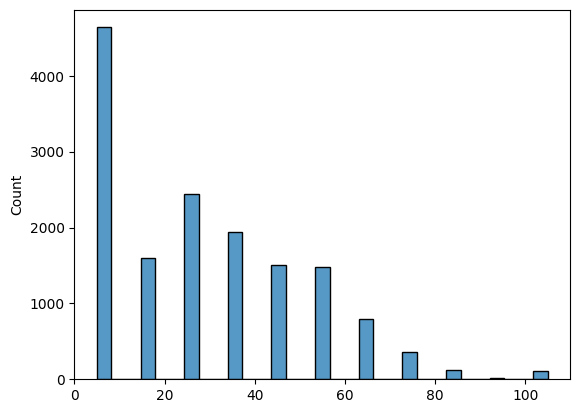

In [31]:
sns.histplot(pred)

In [32]:
submission = pd.read_csv('~/Downloads/best_sub.csv')
submission[col_name] = 0.01 * submission[col_name] + 0.99 * pred
submission.to_csv('~/Downloads/ensemble.csv', index=False)